# Image classification - Transfer Learning

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 10s 0us/step


In [3]:
print(data_dir)

/root/.keras/datasets/flower_photos


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

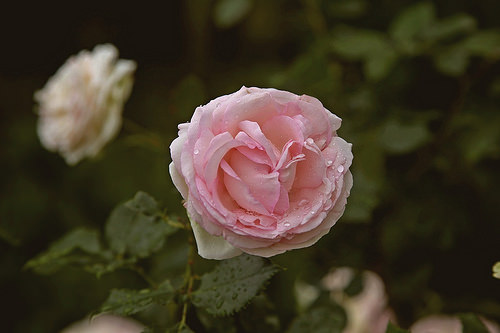

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

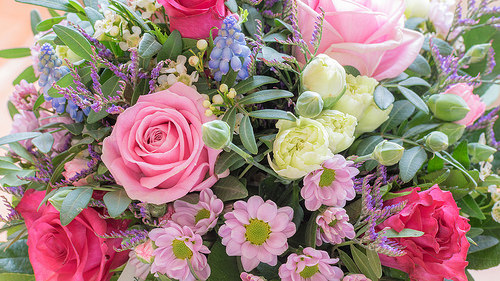

In [6]:
PIL.Image.open(str(roses[2]))

And some tulips:

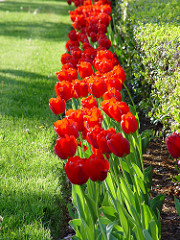

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

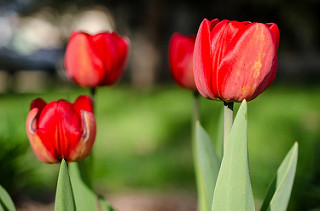

In [8]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [43]:
batch_size = 32 #multiple of 2 will give max util of GPU
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [38]:
num_classes = len(class_names)

## Visualize the data

Here are the first nine images from the training dataset:

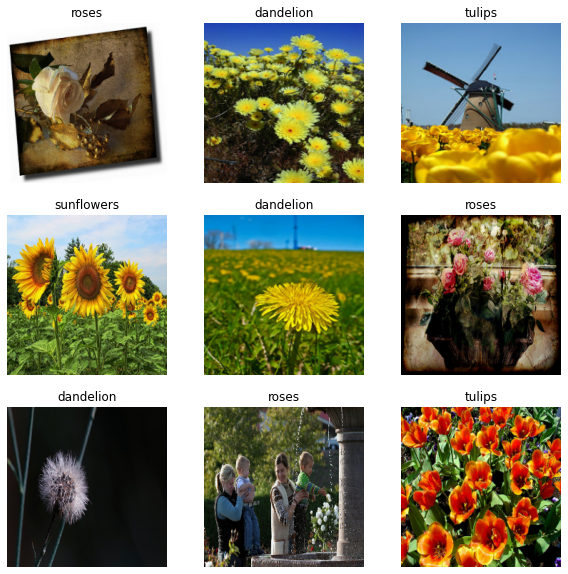

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## Transfer Learning

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

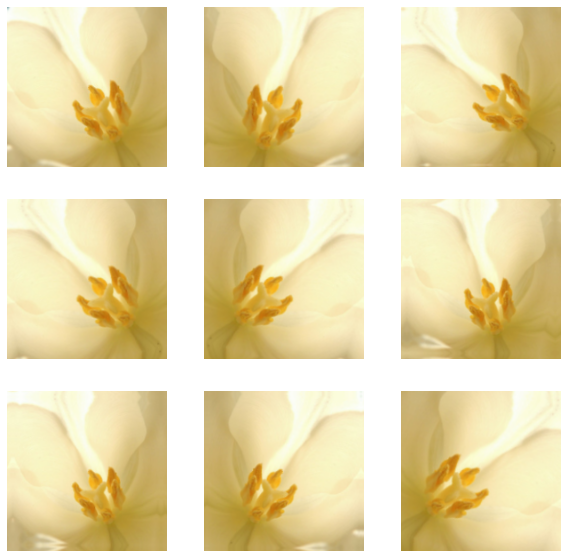

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Model Building

In [25]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

In [26]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input()

In [31]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),include_top=False, weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


In [32]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [33]:
base_model.trainable = False

In [34]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [41]:
prediction_layer = tf.keras.layers.Dense(num_classes, name="outputs", activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [48]:
print(sum(prediction_batch[0]))

tf.Tensor(1.0000001, shape=(), dtype=float32)


In [45]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile and train the model

In [49]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0   

In [52]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

23/23 [==============================] - 6s 136ms/step - loss: 2.1656 - accuracy: 0.2193


In [53]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.17
initial accuracy: 0.22


In [54]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epochs
)

Epoch 1/10
92/92 [==============================] - 21s 189ms/step - loss: 1.6323 - accuracy: 0.3437 - val_loss: 1.1197 - val_accuracy: 0.5627
Epoch 2/10
92/92 [==============================] - 16s 168ms/step - loss: 1.0567 - accuracy: 0.5851 - val_loss: 0.7806 - val_accuracy: 0.7411
Epoch 3/10
92/92 [==============================] - 16s 166ms/step - loss: 0.8198 - accuracy: 0.6884 - val_loss: 0.6250 - val_accuracy: 0.8011
Epoch 4/10
92/92 [==============================] - 16s 167ms/step - loss: 0.6789 - accuracy: 0.7463 - val_loss: 0.5383 - val_accuracy: 0.8188
Epoch 5/10
92/92 [==============================] - 16s 168ms/step - loss: 0.5877 - accuracy: 0.7902 - val_loss: 0.4850 - val_accuracy: 0.8351
Epoch 6/10
92/92 [==============================] - 16s 167ms/step - loss: 0.5571 - accuracy: 0.7980 - val_loss: 0.4464 - val_accuracy: 0.8420
Epoch 7/10
92/92 [==============================] - 16s 171ms/step - loss: 0.5029 - accuracy: 0.8195 - val_loss: 0.4162 - val_accuracy: 0.8488

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

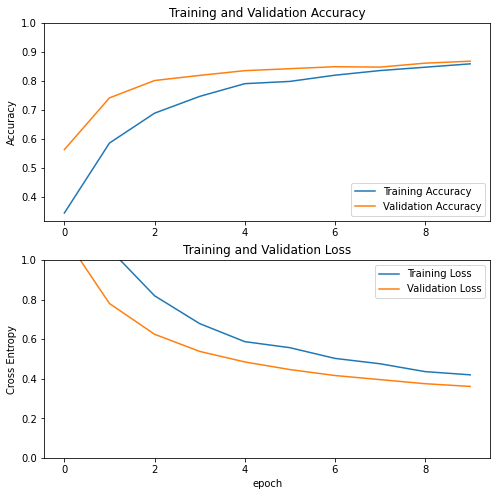

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
base_model.trainable = True

In [58]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

Number of layers in the base model:  175


In [59]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0   

In [62]:
fine_tune_epochs = 10

history_fine = model.fit(train_ds,
                         epochs=fine_tune_epochs,
                         validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 25s 211ms/step - loss: 0.3440 - accuracy: 0.8682 - val_loss: 0.2673 - val_accuracy: 0.9046
Epoch 2/10
92/92 [==============================] - 18s 197ms/step - loss: 0.2593 - accuracy: 0.8999 - val_loss: 0.2444 - val_accuracy: 0.9033
Epoch 3/10
92/92 [==============================] - 19s 199ms/step - loss: 0.1974 - accuracy: 0.9261 - val_loss: 0.2232 - val_accuracy: 0.9142
Epoch 4/10
92/92 [==============================] - 19s 200ms/step - loss: 0.1700 - accuracy: 0.9360 - val_loss: 0.2287 - val_accuracy: 0.9142
Epoch 5/10
92/92 [==============================] - 19s 199ms/step - loss: 0.1392 - accuracy: 0.9441 - val_loss: 0.2253 - val_accuracy: 0.9169
Epoch 6/10
92/92 [==============================] - 18s 196ms/step - loss: 0.0929 - accuracy: 0.9659 - val_loss: 0.1995 - val_accuracy: 0.9305
Epoch 7/10
92/92 [==============================] - 18s 194ms/step - loss: 0.0804 - accuracy: 0.9710 - val_loss: 0.2015 - val_accuracy: 0.9264

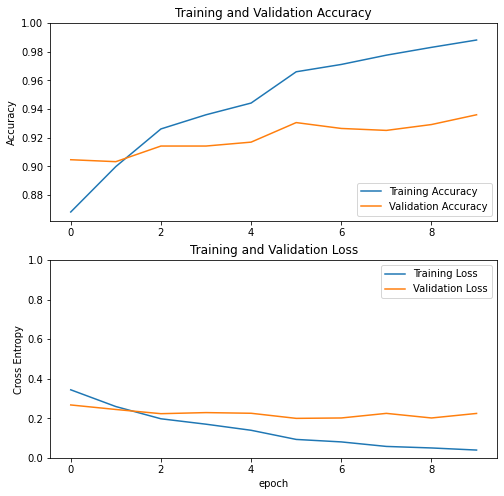

In [63]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [64]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

1/1 [==============================] - 1s 1s/step
This image most likely belongs to sunflowers with a 100.00 percent confidence.


In [65]:
print(predictions)

[[8.5830754e-10 6.1794109e-10 2.6475984e-13 1.0000000e+00 4.4239608e-12]]
